<a href="https://colab.research.google.com/github/shrutikamokashi/Amazon-Reviews-for-Sentiment-Analysis/blob/master/Project_Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import folium
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
mms = MinMaxScaler()

In [0]:
cluster_data = pd.read_csv("Countries_usefulFeatures.csv")
data = pd.read_csv("train_w4.csv")
data2 = pd.read_csv("train_w5.csv")
country_geo = "world-countries.json"
fd_i = pd.read_csv("hfi_cc_2019.csv")

testing = pd.read_csv("tested_worldwide.csv")
max_d_test=testing.groupby(["Country_Region"]).agg({"daily_tested":"max"}).reset_index()

In [0]:
r = {
     'Czech Republic': 'Czechia',
     'DR Congo': 'Congo (Brazzaville)',
     'Democratic Republic of the Congo': 'Congo (Kinshasa)',
     'Ivory Coast': "Cote d'Ivoire",
     'Palestine': 'West Bank and Gaza',
     'South Korea': 'Korea, South',
     'Taiwan': 'Taiwan*',
     'United States': 'US',
    }

In [0]:
max_d_test.Country_Region=max_d_test.Country_Region.replace(to_replace=r)
fd_i = fd_i[fd_i.year==2017]
fd_i = fd_i[["ISO_code","pf_score","hf_score"]]
cluster_data.columns

Index(['Country_Region', 'Population_Size', 'Tourism', 'Date_FirstFatality',
       'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
       'Lockdown_Date', 'Lockdown_Type', 'Country_Code'],
      dtype='object')

In [0]:
data.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [0]:
cluster_data.head()

Country_Region  Population_Size  ...  Lockdown_Type Country_Code
0    Afghanistan         37172386  ...           Full          AFG
1        Albania          2866376  ...           Full          ALB
2        Algeria         42228429  ...           Full          DZA
3        Andorra            77006  ...           Full          AND
4         Angola         30809762  ...            NaN          AGO

[5 rows x 11 columns]

Clustering the data with those 5 columns 'Population_Size', 'Tourism', 'Date_FirstFatality','Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age'

In [0]:
data_to_cluster = cluster_data.copy()
data_to_cluster = data_to_cluster[["Country_Region","Population_Size","Tourism","Date_FirstFatality","Date_FirstConfirmedCase","Latitude","Longtitude","Mean_Age"]]

In [0]:
data_to_cluster.isnull().sum()

Country_Region              0
Population_Size             0
Tourism                     0
Date_FirstFatality         28
Date_FirstConfirmedCase     0
Latitude                    0
Longtitude                  0
Mean_Age                    0
dtype: int64

In [0]:
data_to_cluster.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data_to_cluster.Date_FirstFatality=pd.to_datetime(data_to_cluster.Date_FirstFatality)
data_to_cluster.Date_FirstFatality = data_to_cluster.Date_FirstFatality.astype(np.int64) // 10**9
data_to_cluster.Date_FirstConfirmedCase=pd.to_datetime(data_to_cluster.Date_FirstConfirmedCase)
data_to_cluster.Date_FirstConfirmedCase = data_to_cluster.Date_FirstConfirmedCase.astype(np.int64) // 10**9
data_to_cluster.drop(["Country_Region"],axis=1,inplace=True)
mms.fit(data_to_cluster)
data_transformed = mms.transform(data_to_cluster)

Checking for the optimal K in Kmeans Clustering

In [0]:
Sum_of_squared_distances = []
K = range(1,90)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

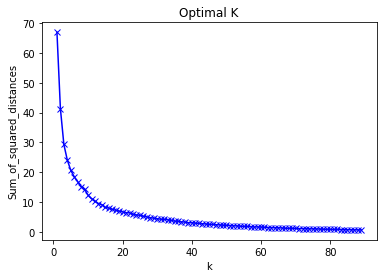

In [0]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Optimal K')
plt.show()

In [0]:
km = KMeans(n_clusters=55,random_state=1995)
km = km.fit(data_transformed)
cluster_data["cluster"] = km.labels_
data.drop("Province_State",axis=1,inplace=True)
data = pd.merge(data,cluster_data,on='Country_Region',how="left")

Creating other useful columns


In [0]:
data.columns

Index(['Id', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities',
       'Population_Size', 'Tourism', 'Date_FirstFatality',
       'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
       'Lockdown_Date', 'Lockdown_Type', 'Country_Code', 'cluster'],
      dtype='object')

In [0]:
temp_data = data.groupby(["Country_Region","Date"]).agg({"ConfirmedCases":"sum","Fatalities":"sum"}).reset_index()
temp_data.columns = ["Country_Region","Date","ConfirmedCases_i","Fatalities_i"]
data.drop_duplicates(["Country_Region","Date"],inplace=True)
data = pd.merge(data,temp_data,on=['Country_Region',"Date"],how="left")
data.drop(["ConfirmedCases","Fatalities"],axis=1,inplace=True)
data.rename(columns={"ConfirmedCases_i":"ConfirmedCases","Fatalities_i":"Fatalities","clusters":"cluster"},inplace=True)

Fatalities percentage



In [0]:
data.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data.isnull().sum()

Id                            0
Country_Region                0
Date                          0
Population_Size               0
Tourism                       0
Date_FirstFatality            0
Date_FirstConfirmedCase       0
Latitude                      0
Longtitude                    0
Mean_Age                      0
Lockdown_Date              3630
Lockdown_Type              3630
Country_Code                  0
cluster                       0
ConfirmedCases                0
Fatalities                    0
dtype: int64

In [0]:
data["Fatalities_rate"]=(data.Fatalities * 100) / data.ConfirmedCases

#Difference between Lockdown Date and First Confirmed Case Date

data["diff_FC_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstConfirmedCase.astype('datetime64'))

In [0]:
#Difference between Lockdown Date and First Confirmed Fatality

data["diff_FF_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstFatality.astype('datetime64'))

In [0]:
tempd2=data2.loc[(data2.Target=="ConfirmedCases"),["Country_Region","Weight"]]
tempd2["Weight_F"] =  data2.loc[(data2.Target=="Fatalities"),["Weight"]].values
tempd2.columns = ["Country_Region","Weight_C","Weight_F"]
tempd2=tempd2.drop_duplicates(["Country_Region"])
data = pd.merge(data,tempd2[["Country_Region","Weight_C","Weight_F"]],on=['Country_Region'],how="left")
fd_i.columns = ["Country_Code","pf_score","hf_score"]
data = pd.merge(data,max_d_test[["Country_Region","daily_tested"]],on=['Country_Region'],how="left")
data=pd.merge(data,fd_i[["Country_Code","pf_score","hf_score"]],on=['Country_Code'],how="left")
data.daily_tested.fillna(data.loc[data.daily_tested>100,"daily_tested"].min(),inplace=True)
data.hf_score.fillna(data.hf_score.median(),inplace=True)
data.pf_score.fillna(data.pf_score.median(),inplace=True)

Line Plots

Checking the clusters

5 first Clusters

Line plot with Date and ConfirmedCases

In [0]:
for i in data.cluster.unique()[:5]:
    test_df2= data[["Country_Region","Date","ConfirmedCases","cluster"]]
    test_df2=test_df2[ (test_df2.cluster==i) & (test_df2.Date > "2020-03-02") ]
    fig = px.line(test_df2, x="Date", y="ConfirmedCases", color='Country_Region')
    fig.show()

Line plot with Date and Fatalities



In [0]:
for i in data.cluster.unique()[:5]:
    test_df2= data[["Country_Region","Date","Fatalities","cluster"]]
    test_df2=test_df2[ (test_df2.cluster==i) & (test_df2.Date > "2020-03-02") ]
    fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')
    fig.show()

Investigating the clusters


In [0]:
m_cluster=data[data.Country_Region == "Morocco"].cluster.unique()[0]
test_df2=data[ (data.cluster==m_cluster) & (data.Date > "2020-03-05") ]
fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')

for i in test_df2.Country_Region.unique():
    x=test_df2[test_df2.Country_Region == i].Lockdown_Date.unique()[0]
    y=test_df2[(test_df2.Date == x) & (test_df2.Country_Region == i)].Fatalities.values

    if (x is not np.NAN) & (len(y) >0) :
        fig.add_trace(go.Scatter(x=[x], y=[int(y)],
                        mode='markers',
                        name=i+'-lockdown-'+test_df2[test_df2.Country_Region == i].Lockdown_Type.unique()[0],
                        marker_symbol="x",
                        hoverinfo = 'text',
                        text=i+" Country lockdown Date "+ x,
                        marker = dict(
                                 size=15,
                                 color="black"
                             ),

                        ))

fig.show()

In [0]:
m_cluster=data[data.Country_Region == "Spain"].cluster.unique()[0]
test_df2=data[ (data.cluster==m_cluster) & (data.Date > "2020-03-05") ]
fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')

for i in test_df2.Country_Region.unique():
    x=test_df2[test_df2.Country_Region == i].Lockdown_Date.unique()[0]
    y=test_df2[(test_df2.Date == x) & (test_df2.Country_Region == i)].Fatalities.values

    if (x is not np.NAN) & (len(y) >0) :
        fig.add_trace(go.Scatter(x=[x], y=[int(y)],
                        mode='markers',
                        name=i+'-lockdown-'+test_df2[test_df2.Country_Region == i].Lockdown_Type.unique()[0],
                        marker_symbol="x",
                        hoverinfo = 'text',
                        text=i+" Country lockdown Date "+ x,
                        marker = dict(
                                 size=15,
                                 color="black"
                             ),

                        ))

fig.show()

Maps

Fatalities_rate

In [0]:
temp =data[(data.Date == max(data.Date)) ]
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)


for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Mean_Age


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)


for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='green', fill='green',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Mean_Age']*2500)).add_to(m)

m

Fatalities_rate and Mean_Age


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'Mean_Age'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="Mean_Age")

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Fatalities_rate and Tourism


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'Tourism'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="Tourism",
             threshold_scale=[14000.0,5000000, 20000000.0, 40000000.0, 60000000.0, 89322000.0]
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(round(temp.iloc[i]['Fatalities_rate'],2))+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])+
                    '<li><bold>Tourism : '+str(temp.iloc[i]['Tourism'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

The Human Freedom Index


In [0]:
temp.pf_score = temp.pf_score.astype("float")
temp.hf_score = temp.hf_score.astype("float")
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'pf_score'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="pf_score",
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'hf_score'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="hf_score")

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Number of tests per day by country


In [0]:
temp.daily_tested = temp.daily_tested.astype("float")
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'daily_tested'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="daily_tested",
             threshold_scale=[0.0, 1000, 5000.0, 10000.0,50000.0,100000.0, 318720.0]
            )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['ConfirmedCases']*1.1)).add_to(m)

m

In [0]:
temp.to_csv("temp.csv",index=False)

Fatalities_rate and the difference between lockDown Date and FirstConfirmedCase


In [0]:
temp.diff_FC_LD.replace({np.NAN:"62"},inplace=True)
temp.diff_FF_LD.replace({np.NAN:"42"},inplace=True)
temp.diff_FC_LD=temp.diff_FC_LD.astype(str)
temp.diff_FF_LD=temp.diff_FF_LD.astype(str)
temp.diff_FC_LD=temp.diff_FC_LD.str[:2]
temp.diff_FF_LD=temp.diff_FF_LD.str[:2]
temp.diff_FC_LD = temp.diff_FC_LD.astype(int)
temp.diff_FF_LD = temp.diff_FF_LD.astype(int)

In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'diff_FC_LD'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="FirstCaseConfirmed_diff_lockdown"
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(round(temp.iloc[i]['Fatalities_rate'],2))+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])+
                    '<li><bold>Tourism : '+str(temp.iloc[i]['Tourism'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Feature Importance 
Correlation

In [0]:
data.pf_score = data.pf_score.astype("float")
data.hf_score = data.hf_score.astype("float")

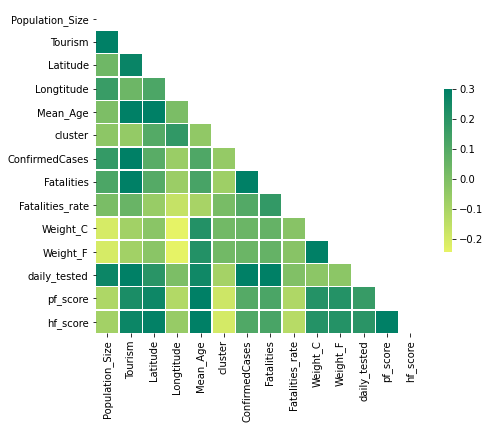

In [0]:
import seaborn as sns
corr = data.drop(["Id"],axis=1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,mask=mask,cmap='summer_r',vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

Feature importance with random forest


In [0]:
def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

In [0]:
train = data.copy()

In [0]:
train.Date_FirstFatality.fillna("2222-11-11",inplace=True)
train.Date_FirstFatality=pd.to_datetime(train.Date_FirstFatality)
train.Date_FirstFatality = train.Date_FirstFatality.astype(np.int64) // 10**9

train.Date_FirstConfirmedCase=pd.to_datetime(train.Date_FirstConfirmedCase)
train.Date_FirstConfirmedCase = train.Date_FirstConfirmedCase.astype(np.int64) // 10**9

train.Date=pd.to_datetime(train.Date)
train.Date = train.Date.astype(np.int64) // 10**9

train.Lockdown_Date.fillna("2111-12-12",inplace=True)
train.Lockdown_Date=pd.to_datetime(train.Lockdown_Date)
train.Lockdown_Date = train.Lockdown_Date.astype(np.int64) // 10**9


train.Lockdown_Type = train.Lockdown_Type.astype("category")
train.Lockdown_Type = train.Lockdown_Type.cat.codes

train.diff_FC_LD.replace({np.NAN:"62"},inplace=True)
train.diff_FF_LD.replace({np.NAN:"42"},inplace=True)
train.diff_FC_LD=train.diff_FC_LD.astype(str)
train.diff_FF_LD=train.diff_FF_LD.astype(str)
train.diff_FC_LD=train.diff_FC_LD.str[:2]
train.diff_FF_LD=train.diff_FF_LD.str[:2]
train.diff_FC_LD = train.diff_FC_LD.astype(int)
train.diff_FF_LD = train.diff_FF_LD.astype(int)

In [0]:
train = train[train.Date == max(train.Date)]

In [43]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           random_state = 141)
rf.fit(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1), train["Fatalities"])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=141, verbose=0, warm_start=False)

In [0]:
fimp = feature_imp(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1),rf)

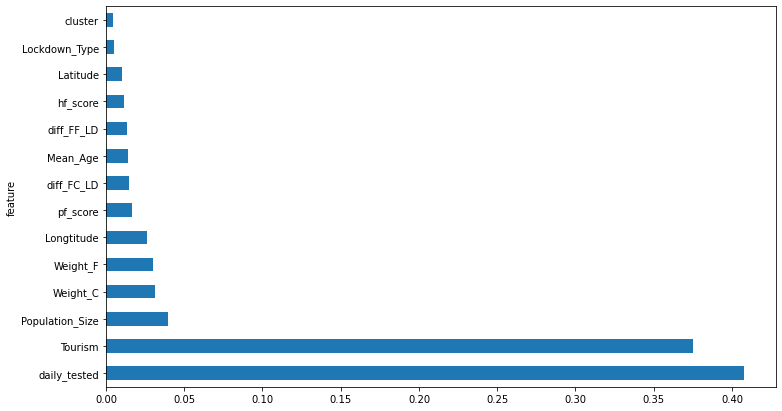

In [45]:
feature_imp(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1),rf).plot('feature', 'importance', 'barh', figsize=(12,7), legend=False)

Checking the correlation between the Fatalities, Tourism and population size


In [46]:
fig = px.scatter(data[(data.Tourism>100000) & (data.Date == max(data.Date)) ],
                 x='Tourism', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Fatalities_rate and Tourism


In [47]:
fig = px.scatter(data[(data.Population_Size>100000) & (data.Date == max(data.Date)) ],
                 x='Population_Size', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [48]:
fig = px.scatter(data[(data.Population_Size>100000) & (data.Date == max(data.Date)) ],
                 x='Weight_F', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [49]:
fig = px.scatter(data[(data.daily_tested>200) & (data.Date == max(data.Date)) ],
                 x='daily_tested', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Predicting the ConfirmCases From Fatalities

In [0]:
data.sort_values(["Country_Region"],inplace=True)


In [0]:
def predict_ConfirmedCases(test_country):
    tmp_data=data[(data.Date == max(data.Date))]
    test_data=tmp_data[tmp_data.Country_Region == test_country]
    train_data = tmp_data[(tmp_data.Country_Region !=test_country) & (tmp_data.Fatalities_rate >= 2) & (tmp_data.Fatalities_rate <= 6)]
    #print(test_data)
    
    mms.fit(train_data[['Fatalities',"Population_Size","Tourism"]])
    data_transformed = mms.transform(train_data[['Fatalities',"Population_Size","Tourism"]])
    
    rg = Ridge(alpha=0.00001)
    rg.fit(data_transformed,train_data["ConfirmedCases"])
   
    predictions=rg.predict(mms.transform(test_data[['Fatalities',"Population_Size","Tourism"]]))
    return pd.DataFrame([test_country,predictions[0]]).transpose()

In [0]:
tmp_df = pd.DataFrame([data.Country_Region.unique()]).T
tmp_df.columns =["Country_Region"]
for i in data.Country_Region.unique():
    d=predict_ConfirmedCases(i)
    tmp_df.loc[tmp_df.Country_Region == i,"predicted_C"] = predict_ConfirmedCases(i)[1].values[0]
tmp_df=pd.merge(tmp_df, data.loc[(data.Date == max(data.Date)),["ConfirmedCases","Country_Region"]],how="left",on="Country_Region")

In [53]:
tmp_df.predicted_C = tmp_df.predicted_C.apply(lambda x: int(round(x,2)))
tmp_df[tmp_df.Country_Region.isin(["Morocco","Egypt","Algeria","Tunisia","France","Spain","Italy","Korea, South"])]

Country_Region  predicted_C  ConfirmedCases
2          Algeria        10591          5723.0
53           Egypt        15605          9400.0
62          France       476768        177094.0
85           Italy       529740        219070.0
91    Korea, South        13437         10909.0
117        Morocco        10739          6063.0
157          Spain       477144        224350.0
170        Tunisia         6288          1032.0